First subsample (stratified) in case we don't have enough time to make enough requests.

In [1]:
# Stratified sampling script for rental listings data
# Performs stratified sampling by suburb, year, and quarter to reduce data to 50%

import pandas as pd
import numpy as np

# Load the data
print("Loading data...")
df = pd.read_csv('../data/curated/rent_features/cleaned_listings.csv')
print(f"Original dataset shape: {df.shape}")
print(f"Original dataset size: {len(df):,} records")

# Display data distribution before sampling
print("\nData distribution before sampling:")
print("Year distribution:")
print(df['year'].value_counts().sort_index())
print("\nQuarter distribution:")
print(df['quarter'].value_counts().sort_index())
print(f"\nUnique suburbs: {df['suburb'].nunique()}")
print(f"Unique year-quarter combinations: {df[['year', 'quarter']].drop_duplicates().shape[0]}")

# Create stratification groups
print("\nCreating stratification groups...")
df['strata'] = df['suburb'].astype(str) + '_' + df['year'].astype(str) + '_' + df['quarter'].astype(str)
strata_counts = df['strata'].value_counts()
print(f"Number of strata: {len(strata_counts)}")
print(f"Strata size distribution:")
print(strata_counts.describe())

# Perform stratified sampling
print("\nPerforming stratified sampling...")
sampled_dfs = []

for stratum in df['strata'].unique():
    stratum_data = df[df['strata'] == stratum]
    
    # Calculate sample size (50% of stratum)
    sample_size = max(1, len(stratum_data) // 2)  # Ensure at least 1 record per stratum
    
    # If stratum has only 1 record, keep it
    if len(stratum_data) == 1:
        sampled_dfs.append(stratum_data)
    else:
        # Random sampling within stratum
        sampled_stratum = stratum_data.sample(n=sample_size, random_state=42)
        sampled_dfs.append(sampled_stratum)

# Combine all sampled strata
sampled_df = pd.concat(sampled_dfs, ignore_index=True)

# Remove the temporary strata column
sampled_df = sampled_df.drop('strata', axis=1)

print(f"\nSampled dataset shape: {sampled_df.shape}")
print(f"Sampled dataset size: {len(sampled_df):,} records")
print(f"Reduction: {((len(df) - len(sampled_df)) / len(df) * 100):.1f}%")

# Display data distribution after sampling
print("\nData distribution after sampling:")
print("Year distribution:")
print(sampled_df['year'].value_counts().sort_index())
print("\nQuarter distribution:")
print(sampled_df['quarter'].value_counts().sort_index())
print(f"\nUnique suburbs: {sampled_df['suburb'].nunique()}")

# Verify stratification is maintained
print("\nVerifying stratification:")
strata_verification = sampled_df.groupby(['suburb', 'year', 'quarter']).size()
print(f"Strata with data after sampling: {len(strata_verification)}")
print("Sample of strata sizes:")
print(strata_verification.head(10))

# Save the sampled data
output_path = '../data/curated/rent_features/cleaned_listings_sampled.csv'
sampled_df.to_csv(output_path, index=False)
print(f"\nSampled data saved to: {output_path}")

# Summary statistics
print("\nSummary:")
print(f"Original records: {len(df):,}")
print(f"Sampled records: {len(sampled_df):,}")
print(f"Sampling ratio: {len(sampled_df)/len(df):.2%}")
print(f"Records removed: {len(df) - len(sampled_df):,}")


Loading data...


/var/folders/xj/ny4zmnqd609bv2rpjzzr11rm0000gn/T/ipykernel_19525/2315601584.py:9: DtypeWarning: Columns (1,15,16,17,19,21,22,24,25,31,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/curated/rent_features/cleaned_listings.csv')


Original dataset shape: (25687, 40)
Original dataset size: 25,687 records

Data distribution before sampling:
Year distribution:
year
2022     2620
2023      340
2024     4065
2025    18662
Name: count, dtype: int64

Quarter distribution:
quarter
3      3357
6      5937
9     15208
12     1185
Name: count, dtype: int64

Unique suburbs: 988
Unique year-quarter combinations: 15

Creating stratification groups...
Number of strata: 2721
Strata size distribution:
count    2721.000000
mean        9.440279
std        24.438703
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max       846.000000
Name: count, dtype: float64

Performing stratified sampling...

Sampled dataset shape: (12882, 40)
Sampled dataset size: 12,882 records
Reduction: 49.9%

Data distribution after sampling:
Year distribution:
year
2022    1295
2023     175
2024    2090
2025    9322
Name: count, dtype: int64

Quarter distribution:
quarter
3     1694
6     2977
9     7596
12     615
Name

Because the ORS isochrone is limited to 500 requests. We will rerun this notebook and update the `curated/rent_features/cleaned_listings.csv` as we impute. 

In [5]:
# First read in the subsampled data
df = pd.read_csv('../data/curated/rent_features/cleaned_listings_sampled.csv')

# Create a new column for isochrones and fill with NaN, we expect 6 columns (3 for driving, 3 for walking with fixed time of 5, 10, 15 minutes respectively)
df[['driving_5min', 'driving_10min', 'driving_15min', 'walking_5min', 'walking_10min', 'walking_15min']] = np.nan

df[['coordinates', 'driving_5min', 'driving_10min', 'driving_15min', 'walking_5min', 'walking_10min', 'walking_15min']]

df.to_csv('../data/raw/missing_isochrones.csv', index=False)


# Running API request below

In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import os 


# Import the GeoUtils class from utils/geo.py
from utils.geo import GeoUtils
from dotenv import load_dotenv

load_dotenv()
APIKEY1 = os.getenv('ORS_API_KEY1')
APIKEY2 = os.getenv('ORS_API_KEY2')
APIKEY3 = os.getenv('ORS_API_KEY3')
APIKEY4 = os.getenv('ORS_API_KEY4')
APIKEY5 = os.getenv('ORS_API_KEY5')
# Initialize GeoUtils 
geoutils = GeoUtils(ors_api_key=APIKEY1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
OpenRouteService client initialized successfully.


In [19]:
# read in the missing isochrones using geopandas
gdf = gpd.read_file('../data/raw/missing_isochrones.csv') 

# get the first 500 
gdf_tmp = gdf.head(500) 

In [22]:
# Convert coordinates to Point objects from shapely
from shapely.geometry import Point
from shapely import wkt

# Check the format of the coordinates column
sample_coords = gdf_tmp['coordinates'].iloc[0]
print(f"Sample coordinate format: {sample_coords}")

# Convert WKT POINT strings to Point objects
if isinstance(sample_coords, str) and sample_coords.startswith('POINT'):
    # Handle WKT POINT format: "POINT (lon lat)"
    gdf_tmp['geometry'] = gdf_tmp['coordinates'].apply(
        lambda coord: wkt.loads(coord)
    )
    print("Successfully converted WKT POINT strings to Point objects")
else:
    print("Unexpected coordinate format. Expected WKT POINT format.")

# Verify the conversion worked
print(f"\nCreated geometry column with {gdf_tmp['geometry'].notna().sum()} valid points")
print("Sample geometry objects:")
print(gdf_tmp['geometry'].head())
print(f"\nGeometry type: {type(gdf_tmp['geometry'].iloc[0])}")


Sample coordinate format: POINT (-37.8058235 144.9940691)
Successfully converted WKT POINT strings to Point objects

Created geometry column with 500 valid points
Sample geometry objects:
0    POINT (-37.8058235 144.9940691)
1     POINT (-37.8111571 145.008908)
2    POINT (-37.8041915 144.9956615)
3     POINT (-37.8111571 145.008908)
4    POINT (-37.8109899 145.0067059)
Name: geometry, dtype: object

Geometry type: <class 'shapely.geometry.point.Point'>


/var/folders/xj/ny4zmnqd609bv2rpjzzr11rm0000gn/T/ipykernel_19525/2102773548.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_tmp['geometry'] = gdf_tmp['coordinates'].apply(


In [28]:
gdf_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   property_id          500 non-null    object
 1   bedrooms             500 non-null    object
 2   bathrooms            500 non-null    object
 3   car_spaces           500 non-null    object
 4   property_type        500 non-null    object
 5   land_area            500 non-null    object
 6   property_features    500 non-null    object
 7   suburb               500 non-null    object
 8   postcode             500 non-null    object
 9   year                 500 non-null    object
 10  quarter              500 non-null    object
 11  age_0_to_19          500 non-null    object
 12  age_20_to_39         500 non-null    object
 13  age_40_to_59         500 non-null    object
 14  age_60_plus          500 non-null    object
 15  agency_name          500 non-null    object
 16  agent_na

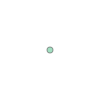

In [ ]:
gdf_tmp[['driving_5min', 'driving_10min', 'driving_15min']] = gdf_tmp['geometry'].apply(lambda x: geo_utils.get_isochrone_with_delay(profile="driving-car", range_values=[300, 600, 900], coordinate=x))
# generate a list of columns called isochrone_driving_300, isochrone_driving_600, isochrone_driving_900
gdf[['isochrone_driving_5', 'isochrone_driving_10', 'isochrone_driving_15']] = gdf['geometry'].apply(lambda x: geo_utils.get_isochrone_with_delay(profile="driving-car", range_values=[300, 600, 900], coordinate=x))

gdf[['isochrone_driving_300', 'isochrone_driving_600', 'isochrone_driving_900']]


